In [1]:
import numpy as np 
import bagpipes as pipes
from astropy.io import fits
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u

In [2]:
mpl.rcParams['text.usetex'] = True

# Load photometry data and filter curve

In [29]:
version = 'space_homo_upright'
#drop_telescope = ['UKIRT', 'GEMINI', 'SPITZER']
#drop_telescope = ['UKIRT', 'GEMINI', ] #low-resolution
#drop_telescope = ['UKIRT', 'GEMINI', 'SPITZER', 'CFHT', 'VISTA']#ground telescope except Subaru
#drop_telescope = []
drop_band=['F125W', 'F160W']
#drop_band=[]

In [30]:
def load_photometry_data(version,):
    fluxes = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/flux_sum_{version}.csv', index_col=0).drop(drop_telescope, axis=1).drop(drop_band, axis=0).stack().values
    errors = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/error_sum_{version}.csv', index_col=0).drop(drop_telescope, axis=1).drop(drop_band, axis=0).stack().values
    photometry = np.c_[fluxes, errors]
    
    return photometry   

In [31]:
def load_filter_path(version,):
    stack_df = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/flux_sum_{version}.csv', index_col=0).drop(drop_telescope,axis=1).drop(drop_band, axis=0).stack().reset_index()
    filters = stack_df['level_0']
    telescopes = stack_df['level_1']
    filter_list = [glob(f'/home/lupengjun/OII_emitter/data/filter/{telescope}/*{band}*')[0] for telescope, band in zip(telescopes, filters)]
    return filter_list

In [32]:
galaxy = pipes.galaxy(version, load_photometry_data, spectrum_exists=False, filt_list=load_filter_path(version=version,))

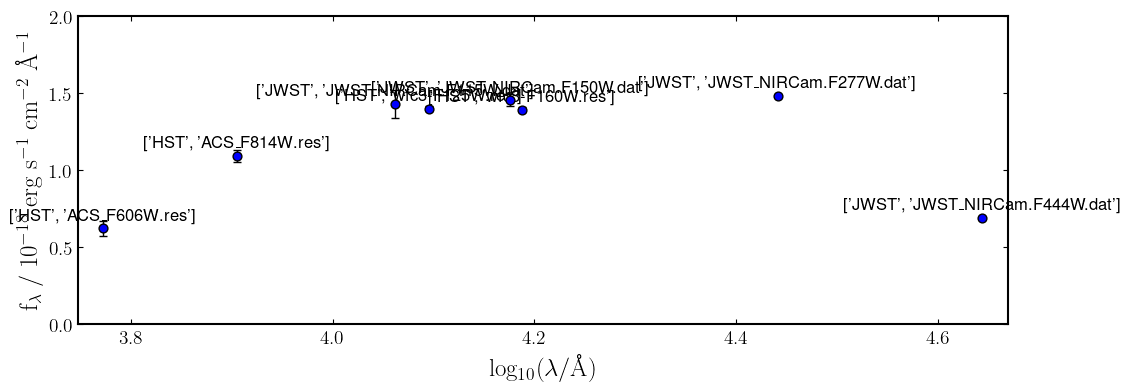

In [24]:
fig, axes, y_scale = galaxy.plot(return_y_scale=True, show=False)
for i in range(galaxy.photometry.shape[0]):
    x, y = np.log10(galaxy.photometry[i,0]), galaxy.photometry[i,1]*10**(-y_scale[0])+0.05
    #text = galaxy.filt_list[i].split('/')[-1].split('.')[-2]
    text = galaxy.filt_list[i].split('/')[-2:]
    #print(x, y, galaxy.filt_list[i])
    axes[0].text(x, y, text, ha='center')
axes[0].set_ylim(0, 2.0)
# plt.savefig(f'../output/SED_photometry_{version}_1118.png')
plt.show()

check scatter band

# Do SED fitting

Set galaxy parameters

In [33]:
#Tau-model
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

#delayed Tau-model
delayed = {}                         # Delayed Tau model t*e^-(t/tau)
delayed["age"] = (0.1, 15.)           # Time since SF began: Gyr
delayed["tau"] = (0.3, 10.)           # Timescale of decrease: Gyr
delayed["massformed"] = (1., 15.)
delayed["metallicity"] = (0., 2.5)

#double-power law
dblplaw = {}                        
dblplaw["tau"] = (0., 15.)                # Vary the time of peak star-formation between
                                          # the Big Bang at 0 Gyr and 15 Gyr later. In 
                                          # practice the code automatically stops this
                                          # exceeding the age of the universe at the 
                                          # observed redshift.            
dblplaw["alpha"] = (0.01, 1000.)          # Vary the falling power law slope from 0.01 to 1000.
dblplaw["beta"] = (0.01, 1000.)           # Vary the rising power law slope from 0.01 to 1000.
dblplaw["alpha_prior"] = "log_10"         # Impose a prior which is uniform in log_10 of the 
dblplaw["beta_prior"] = "log_10"          # parameter between the limits which have been set 
                                          # above as in Carnall et al. (2017).
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0., 2.5)

#lognormal
lognormal = {}                       # lognormal SFH
lognormal["tmax"] = (0.1, 15)        # Age of Universe at peak SF: Gyr
lognormal["fwhm"] = (0.1, 15)        # Full width at half maximum SF: Gyr
lognormal["massformed"] = (1., 15.)
lognormal["metallicity"] = (0., 2.5)

#dust
dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 5.)                     # Vary Av between 0 and 2 magnitudes

#nebula
nebular = {}
nebular["logU"] = (-4, -2)

#AGN
agn = {}
agn['alphalam'] = (-2.5, -0.5) #Power law slope of the AGN continuum at lambda < 5000A
agn['betalam'] = (-0.5, 1.5) #Power law slope of the AGN continuum at lambda > 5000A
agn['hanorm'] = (0., 2.5*10**(-17)) #Halpha luminosity erg/s/cm^2
agn['sigma'] = (1000., 5000.) #Velocity dispersion km/s
agn['f5100A'] = (0., 10**(-19)) #5100A luminosity erg/s/cm^2

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["redshift"] = 0.924  # Vary observed redshift from 0.9 to 1 #spetrum redshift=0.924
#fit_instructions['exponential'] = exp
#fit_instructions['delayed'] = delayed
fit_instructions["dblplaw"] = dblplaw
#fit_instructions['lognormal'] = lognormal   
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular #add nebular emission
fit_instructions["agn"] = agn #add agn

fitting process

In [34]:
fit = pipes.fit(galaxy, fit_instructions, run=f'{version}_agn_dblplaw')
fit.fit(verbose=False)


Bagpipes: fitting object space_homo_upright

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =   12
 *****************************************************

Completed in 694.5 seconds.
 ln(ev)=   260.88338188724765      +/-  0.21077839243894880     
 Total Likelihood Evaluations:       296298
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
agn:alphalam                  -1.434     -0.946     -0.655
agn:betalam                   -0.125      0.028      0.213
agn:f5100A                     0.000      0.000      0.000
agn:hanorm                     0.000      0.000      0.000
agn:sigma                   1605.632   2614.631   3887.453
dblplaw:a

/home/lupengjun/anaconda3/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1
/home/lupengjun/anaconda3/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/lupengjun/anaconda3/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass


In [35]:
fig = fit.plot_spectrum_posterior(save=True, show=True)
fig = fit.plot_sfh_posterior(save=True, show=True)
fig = fit.plot_corner(save=True, show=True)

diagnostic plots

In [26]:
fit.posterior.get_advanced_quantities()

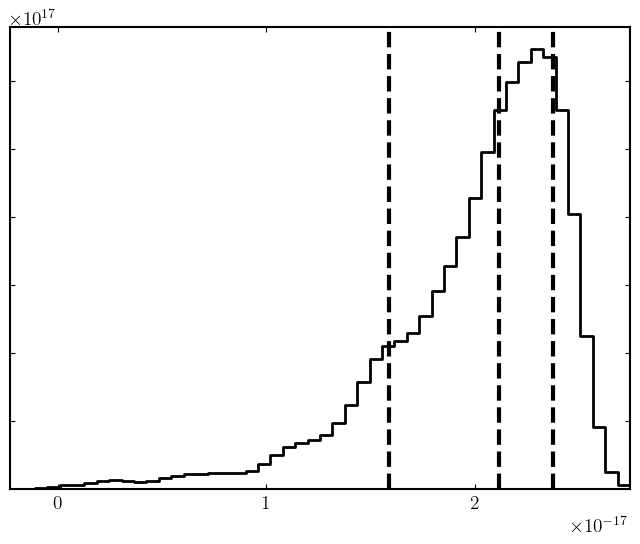

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
pipes.plotting.hist1d(fit.posterior.samples['agn:hanorm'],ax)

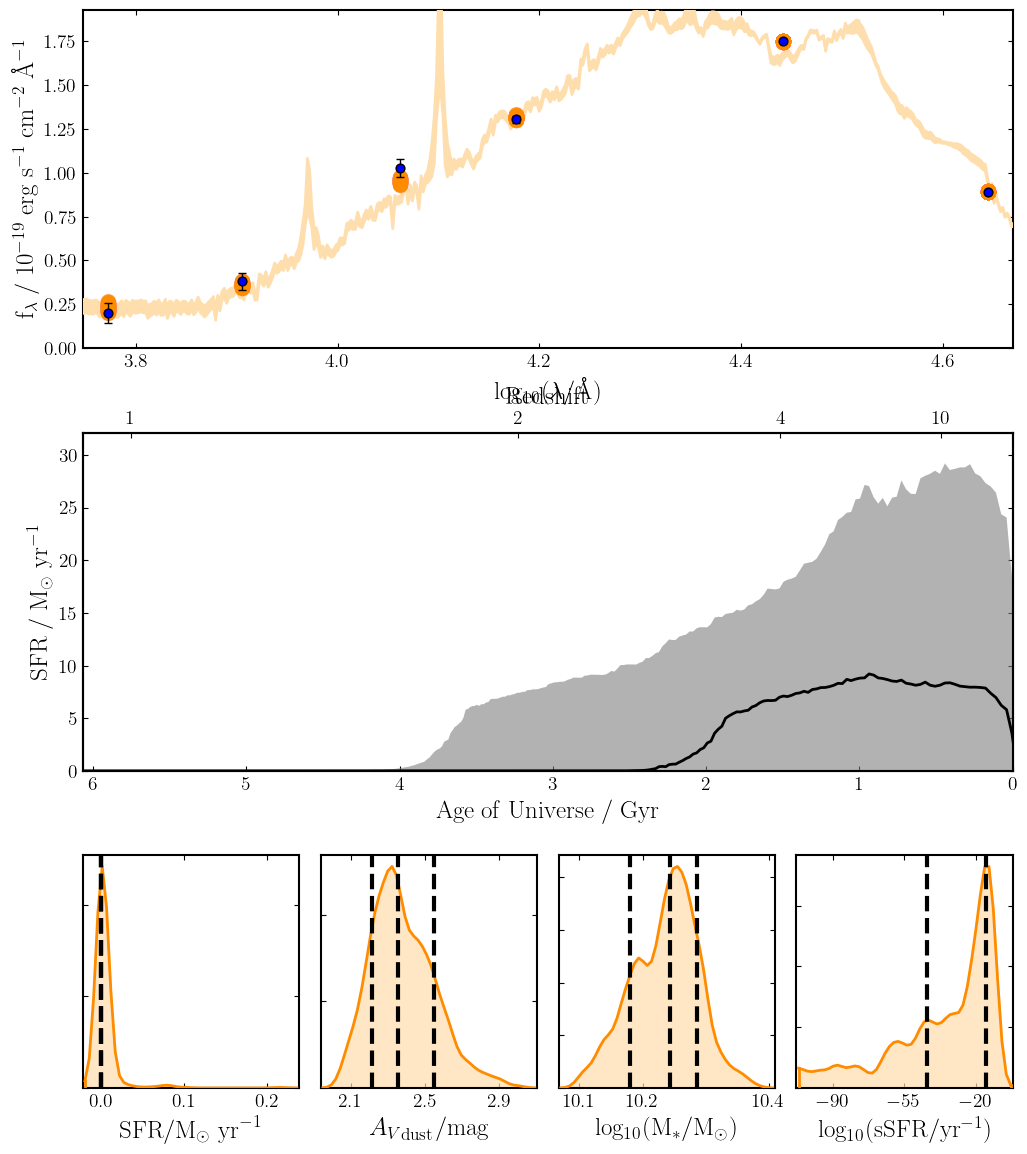

In [37]:
fig = plt.figure(figsize=(12, 14))
gs = mpl.gridspec.GridSpec(11, 4, hspace=4., wspace=0.1)
ax1 = plt.subplot(gs[:4, :])
pipes.plotting.add_observed_photometry(fit.galaxy, ax1, zorder=10)
pipes.plotting.add_photometry_posterior(fit, ax1)
ax2 = plt.subplot(gs[4:8, :])
pipes.plotting.add_sfh_posterior(fit, ax2)
labels = ["sfr", "dust:Av", "stellar_mass", "ssfr"]
post_quantities = dict(zip(labels, [fit.posterior.samples[l] for l in labels]))
axes = []
for i in range(4):
    axes.append(plt.subplot(gs[8:, i]))
    pipes.plotting.hist1d(post_quantities[labels[i]], axes[-1], smooth=True, label=labels[i])
# plt.suptitle(run)
plt.show()
plt.clf()
plt.close()

In [1]:
versions = ['homo_ellipse_v1', 'space_homo_ellipse_v1', 'space_homo_downleft', 'space_homo_upright']
SFH_models = ['exponential', 'delayed', 'lognormal', 'dblplaw']

In [1]:
import SED_fitting_bagpipes as tools

In [13]:
# for version in versions:
version = 'COSMOS2020'
for SFH_model in SFH_models:
    fit = tools.diagnostic_plot(version, SFH_model)


Results loaded from pipes/posterior/COSMOS2020_exponential_fix_z/COSMOS2020.h5


Results loaded from pipes/posterior/COSMOS2020_delayed_fix_z/COSMOS2020.h5


Results loaded from pipes/posterior/COSMOS2020_lognormal_fix_z/COSMOS2020.h5



/home/lupengjun/anaconda3/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1



Results loaded from pipes/posterior/COSMOS2020_dblplaw_fix_z/COSMOS2020.h5



In [16]:
fit.posterior.samples.keys()

dict_keys(['dust:Av', 'exponential:age', 'exponential:massformed', 'exponential:metallicity', 'exponential:tau', 'nebular:logU', 'stellar_mass', 'formed_mass', 'sfr', 'ssfr', 'nsfr', 'mass_weighted_age', 'tform', 'tquench', 'mass_weighted_zmet', 'sfh', 'photometry', 'spectrum_full', 'uvj', 'chisq_phot', 'dust_curve'])

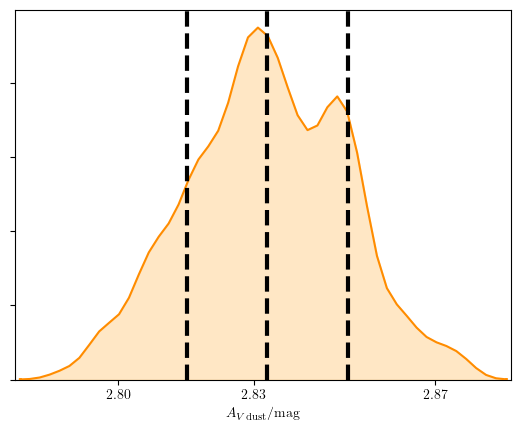

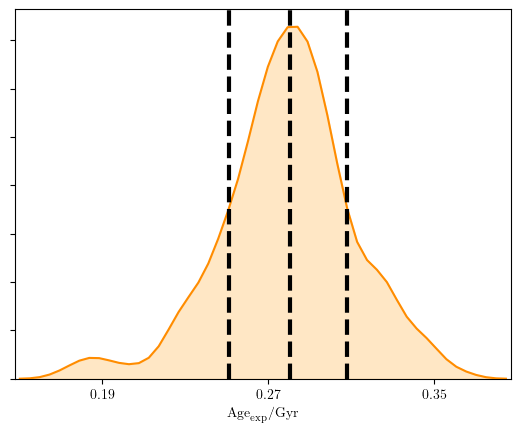

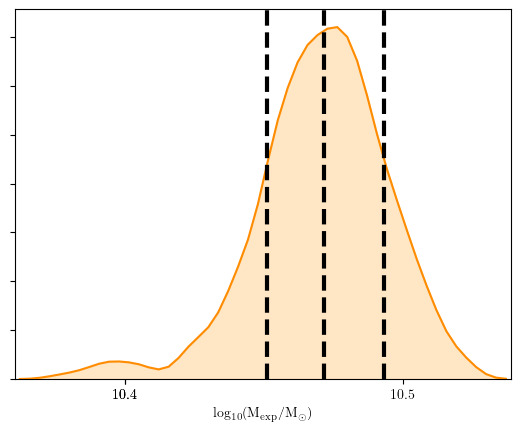

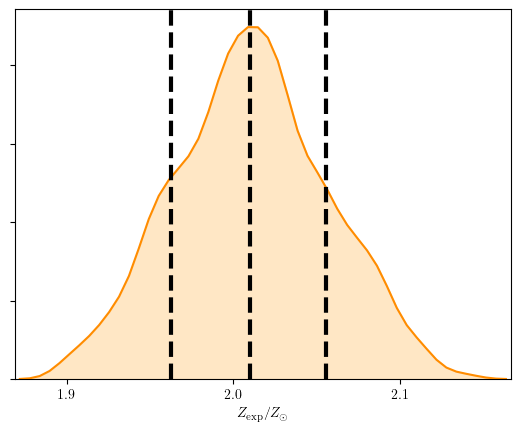

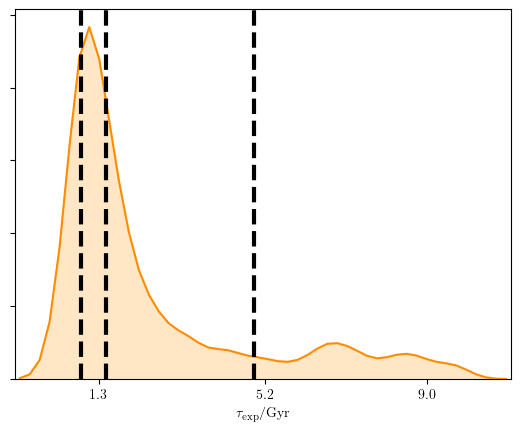

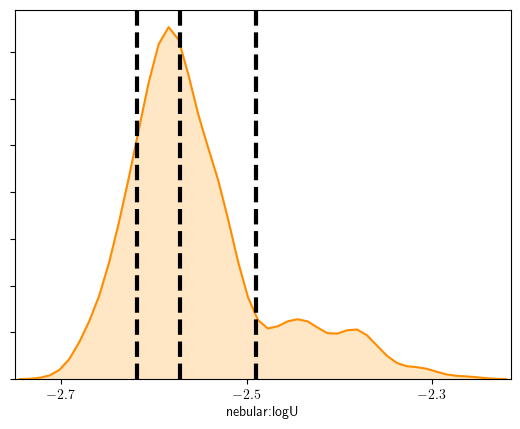

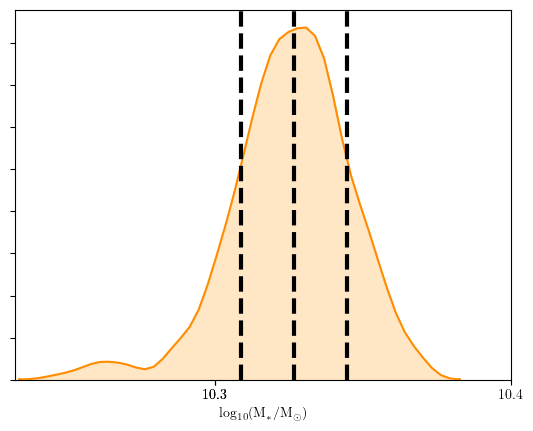

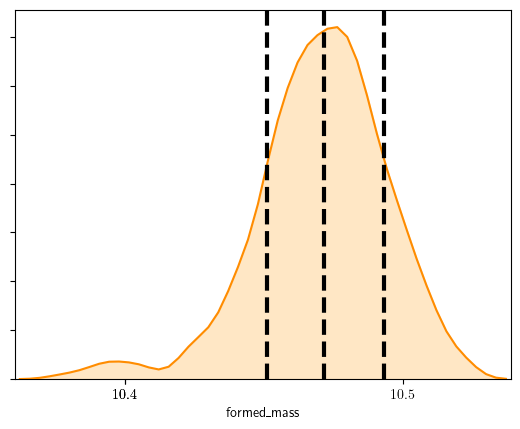

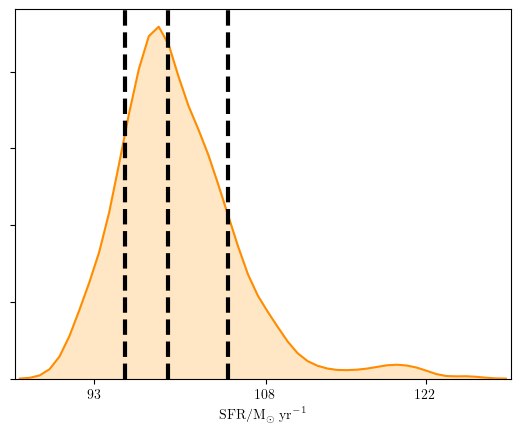

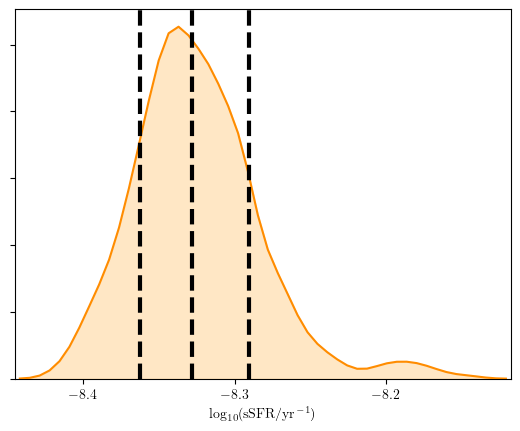

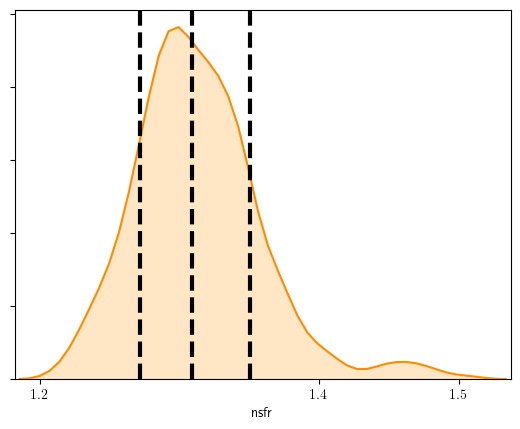

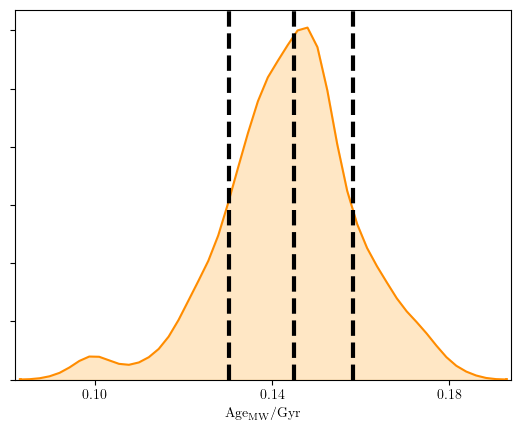

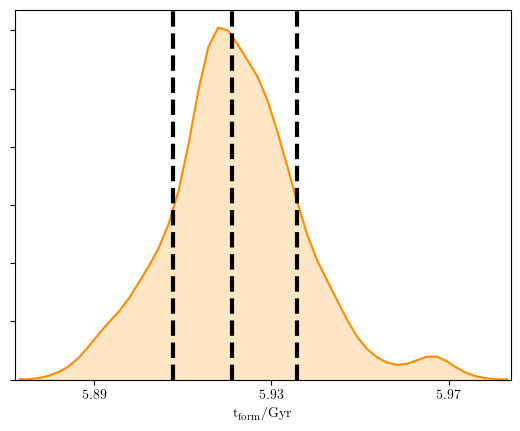

/home/lupengjun/anaconda3/lib/python3.10/site-packages/bagpipes/plotting/general.py:178: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(range)


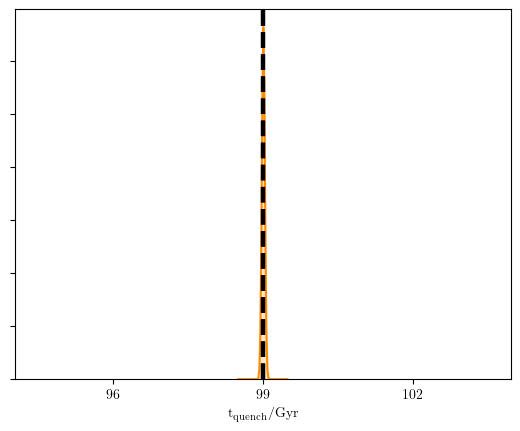

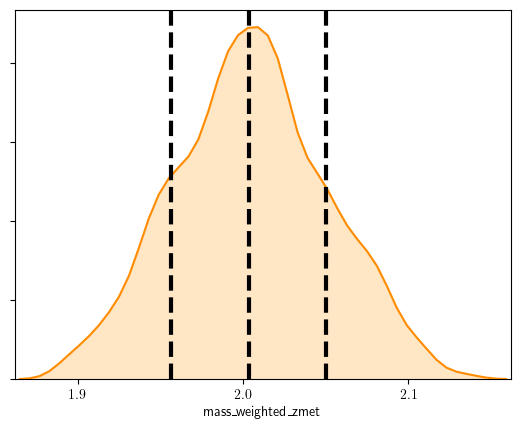

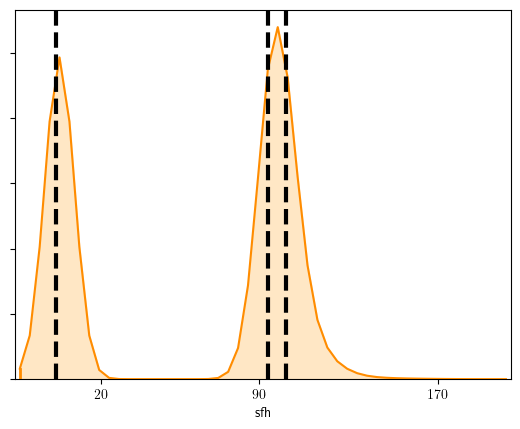

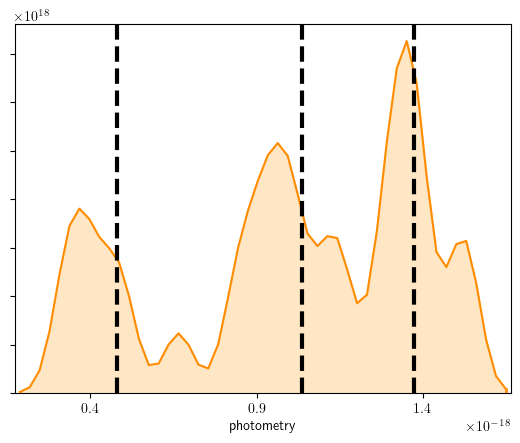

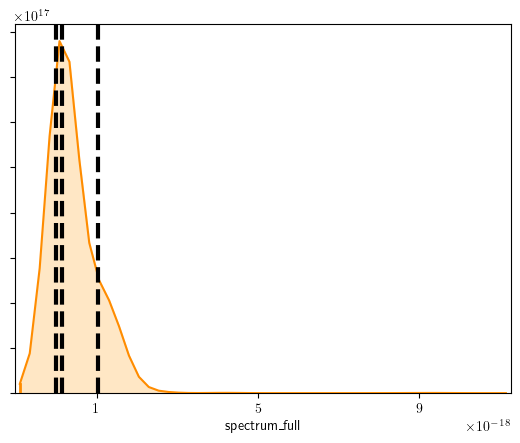

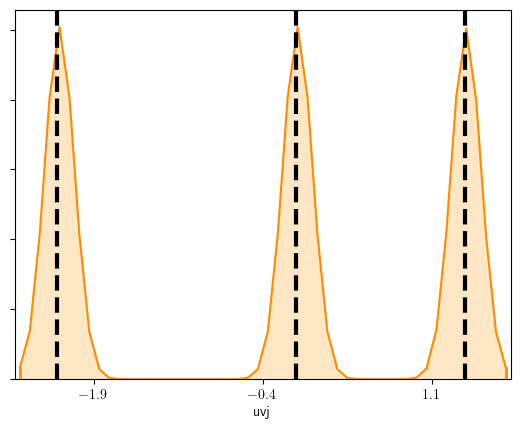

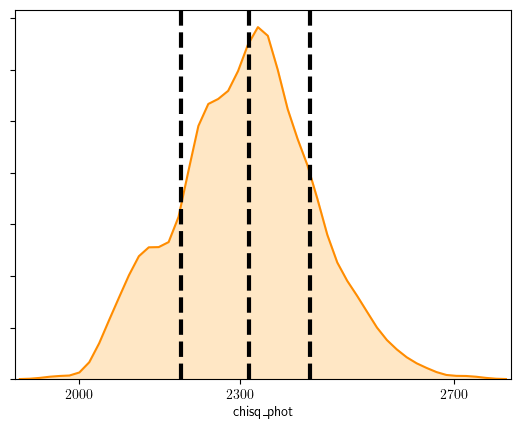

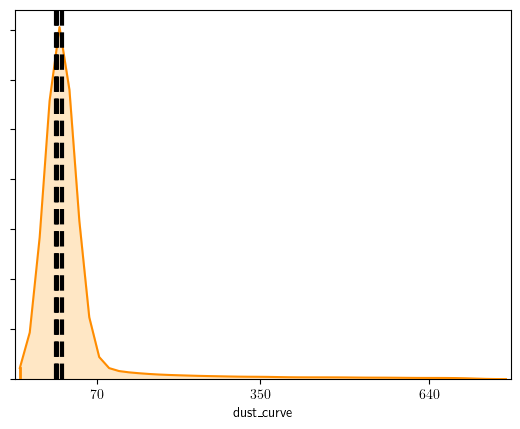

In [15]:
for key in fit.posterior.samples.keys():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    pipes.plotting.hist1d(fit.posterior.samples[key], ax, smooth=True, label=key)
    plt.show()


Results loaded from pipes/posterior/homo_ellipse_v1_exponential_fix_z/homo_ellipse_v1.h5


Results loaded from pipes/posterior/homo_ellipse_v1_delayed_fix_z/homo_ellipse_v1.h5


Results loaded from pipes/posterior/homo_ellipse_v1_lognormal_fix_z/homo_ellipse_v1.h5



/home/lupengjun/anaconda3/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1



Results loaded from pipes/posterior/homo_ellipse_v1_dblplaw_fix_z/homo_ellipse_v1.h5


Results loaded from pipes/posterior/space_homo_downleft_exponential_fix_z/space_homo_downleft.h5


Results loaded from pipes/posterior/space_homo_downleft_delayed_fix_z/space_homo_downleft.h5


Results loaded from pipes/posterior/space_homo_downleft_lognormal_fix_z/space_homo_downleft.h5



/home/lupengjun/anaconda3/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1



Results loaded from pipes/posterior/space_homo_downleft_dblplaw_fix_z/space_homo_downleft.h5


Results loaded from pipes/posterior/space_homo_upright_exponential_fix_z/space_homo_upright.h5


Results loaded from pipes/posterior/space_homo_upright_delayed_fix_z/space_homo_upright.h5


Results loaded from pipes/posterior/space_homo_upright_lognormal_fix_z/space_homo_upright.h5



/home/lupengjun/anaconda3/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1



Results loaded from pipes/posterior/space_homo_upright_dblplaw_fix_z/space_homo_upright.h5



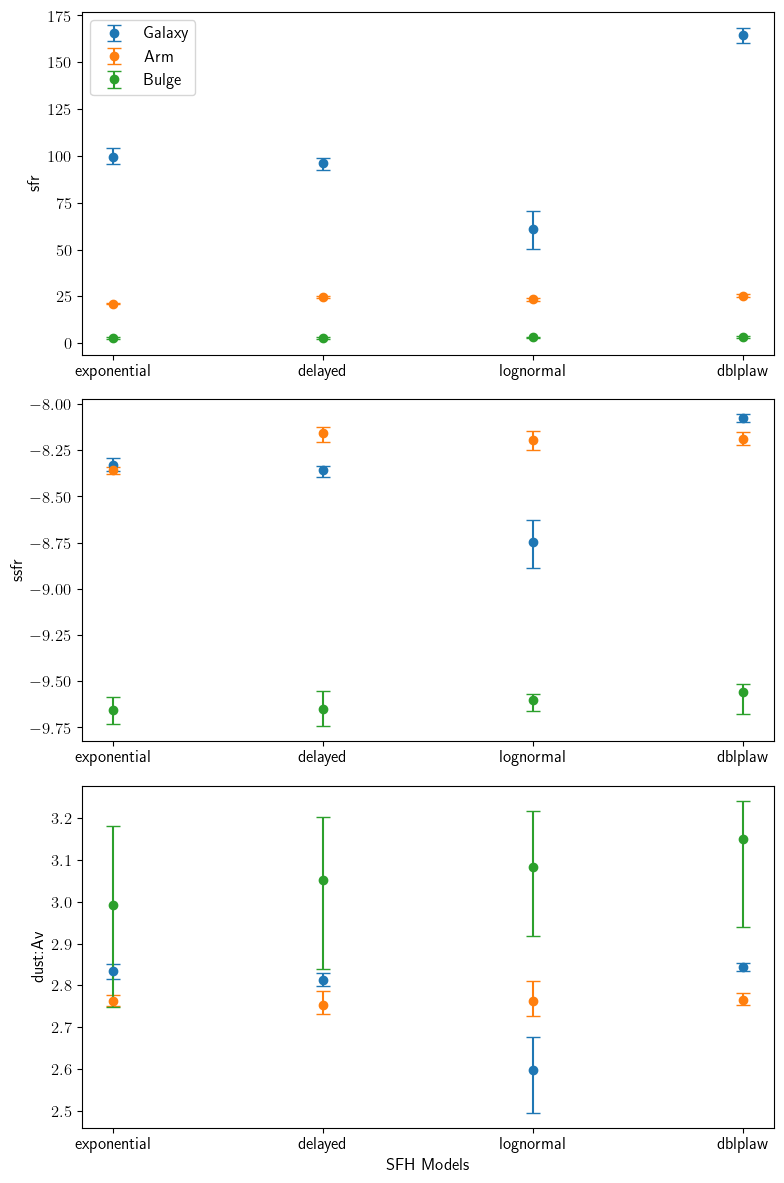

In [1]:
import SED_fitting_bagpipes as tools
results_dic = tools.results_plot(versions=['homo_ellipse_v1', 'space_homo_downleft', 'space_homo_upright'],
                    labels=['sfr', 'ssfr', 'dust:Av'])

In [6]:
import numpy as np
np.percentile(results_dic[1]['homo_ellipse_v1']['dblplaw:massformed'], 50)

KeyError: 'dblplaw:massformed'

<ErrorbarContainer object of 3 artists>

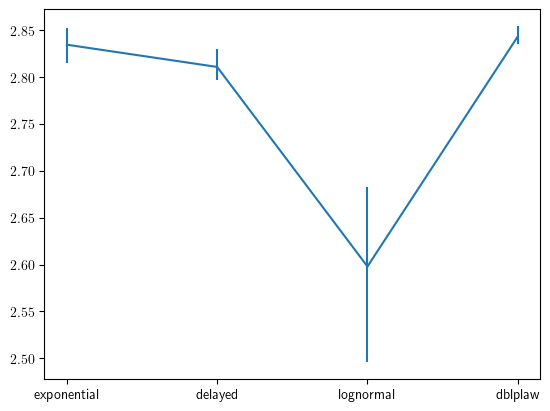

In [12]:
import matplotlib.pyplot as plt
import numpy as np
x = ['exponential', 'delayed', 'lognormal', 'dblplaw']
y = np.array([2.8346737942981237, 2.8109387419266874, 2.597959035828757, 2.8434532299872544])
yerr = np.array([[2.81530852, 2.79691303, 2.49579414, 2.83535077], [2.85235455, 2.83015164, 2.68323489, 2.85445592], ])
plt.errorbar(x, y, np.abs(yerr-y))

In [2]:
samples = results_dic[1]

In [12]:
mass_array = samples['homo_ellipse_v1']['delayed']['delayed:massformed']
age_array = samples['homo_ellipse_v1']['delayed']['delayed:age']
tau_array = samples['homo_ellipse_v1']['delayed']['delayed:tau']
sfr_array = samples['homo_ellipse_v1']['delayed']['sfr']

In [13]:
np.percentile(mass_array, 50), np.percentile(age_array, 50), np.percentile(tau_array, 50), 
np.percentile(sfr_array, 50)

96.29169060566483

In [34]:
for i in np.random.randint(len(age_array), size=10):
    sfr_pros = parametric_sfr(times=np.array([0]), sfh=4, tavg=0.1, mass=10**mass_array[i], tage=age_array[i], tau=tau_array[i],)[0]
    sfr_bag = sfr_array[i]
    print(sfr_pros-sfr_bag)

-0.014247085359386347
-0.011190541461019166
-0.005489407385070422
-0.005138877718366075
-0.006740369949312708
-0.006344929460084359
-0.011566157446623038
-0.010449038310198944
-0.008321938791794992
-0.00823799496500044


In [35]:
len(age_array)

500

In [16]:
from prospect.plotting.sfh import parametric_sfr
import numpy as np
# print(parametric_sfr(mass=2e10, tage=0.4, tau=0.1,))
print(parametric_sfr(times=np.array([0]), sfh=4, tavg=0.1, mass=10**np.percentile(mass_array, 50), tage=np.percentile(age_array, 50), tau=np.percentile(tau_array, 50),))

[95.19444739]
